# Fuzzy upravljanje poljoprivrednom proizvodnjom u plasteniku

<center><img src="Dinko.png" alt="drawing" width="50%"/></center>

### KRATAK OPIS PROBLEMA 
<p>
 Kao što nam je poznato u plastenicima i staklenicima se vrlo brzo mijenjaju klimatski uvjeti
 i zbog toga nam je potrebna automatska regulacija ventilacije kako bi se potpuno iskoristila funkcionalnost objekata.

Zbog previsoke temperature u objektu dolazi do izduživanja internodija na biljkama dok preniska 
temperatura zaustavlja njezin rast. Kod ručnog otvaranja ventilacije nikad ne možemo pravovremeno 
odrediti kada je potrebno otvaranje ili zatvaranje ventilacije, a već mala zakašnjenja mogu dovesti do
 ekstremno visokih temperatura što je veliki šok za biljke.

Sa automatikom se ventilacija vrši postepenim otvaranjem prozora čime se onemogućavaju nagle 
promijene temperature koje uzrokuju šokiranje biljaka. Kod određene brzine i smjera vjetra automatika 
po potrebi pritvara ili zatvara ventilacijske otvore kako bi se spriječilo oštećenje objekta kod nevrjemena.<sup>[1](#izvori)</sup>
</p>

### DEFINICIJA ULAZNIH I IZLAZNIH VARIJABLI

Projekat bi bio realiziran na platformi Raspberry pi pico w, zbog svoje podrške za Python programski jezik i zato što ima ugrađen WiFi čip na sebi koji ćemo iskoristiti u projektu. U nastavku su definisane ulazne i izlazne varijable koje ćemo koristiti za mikrokontroler:

#### Ulazne varijable

Za naš fuzzy kontroler smo koristili 5 ulaznih varijabli:

1. **Varijabla:** Temperatura zraka  
   **Senzor:** `DHT 22`

2. **Varijabla:** Vlažnost zraka  
   **Senzor:** `DHT 22`

3. **Varijabla:** Brzina vjetra  
   **Senzor:** `Adafruit anemometar`

4. **Varijabla:** AQ indeks  
   **API:** [dajposlic.pythonanywhere.com](https://dajposlic.pythonanywhere.com) (što je omotač za [AQICN API](https://aqicn.org/city/sarajevo/))

5. **Varijabla:** Da li pada kiša  
   **Senzor:** `Senzor za kišu`


#### Izlazne varijable

Izlazna varijabla je tipa **bool** i predstavlja signal mikrokontroleru da treba otvoriti prozore.

> ili

Izlazna varijabla je tipa **double** i predstavlja koliko će mikrokontroler otvoriti prozore.




### DEFINISANJE FUZZY SKUPOVA

Povrće na koje ćemo se fokusirati u ovom zadatku će biti paradajz pa smo definisali fuzzy skupove prema idealnim uslovima za uzgoj paradajza: 

1. **Varijabla:** Temperatura zraka  
   **Tip varijable:** `kontinualna`  
   **Domen:** [-40°C, 80°C]<sup>[2](#izvori)</sup>  
   **Lingvistički model varijable:** <sup>[3](#izvori)</sup>  
   - `prehladno`  [-40°C, 16°C]
   - `hladno`  [15°C, 22°C]  
   - `taman-za-noc`  [17°C, 18°C] 
   - `taman-za-dan`  [21°C, 27°C]  
   - `vruće`  [26°C, 35°C]  
   - `prevruće`  [34°C, 80°C]  


2. **Varijabla:** Vlažnost zraka  
   **Tip varijable:** `kontinualna`  
   **Domen:** [0%, 100%]  
   **Lingvistički model varijable:**<sup>[3](#izvori)</sup>  
   - `presuho`    [0%, 50%] - 
   - `suho`    [45%, 83%]  -
   - `taman-za-noć`    [65%, 75%] -
   - `taman-za-dan`    [80%, 90%]  -
   - `prevlažno`  [89%, 100%]   -


3. **Varijabla:** Brzina vjetra  
   **Tip varijable:** `kontinualna`  
   **Domen:** [0 m/s, 32.4 m/s]  
   **Lingvistički model varijable:**<sup>[4 5](#izvori)</sup>  
   - `nema`    [0 m/s, 1.4 m/s]  -
   - `slab`    [1.3 m/s, 4 m/s]  -
   - `umjeren`    [3.5 m/s, 6.7 m/s]  
   - `kritican`    [4.5 m/s, 8.9 m/s]
   - `opasan`  [6.4 m/s, 8.9 m/s ]  
   - `jako-opasan`  [14.5 m/s, 32.4 m/s ]  

4. **Varijabla:** AQ indeks  
   **Tip varijable:** `kontinualna`  
   **Domen:** [0, +∞)  
   **Lingvistički model varijable:**<sup>[5](#izvori)</sup>
   - `dobro`    [0, 50]  -
   - `umjereno`    [51, 100]  -
   - `blago nezdravo`    [101, 150]  
   - `nezdravo`    [151, 200]  
   - `pravo nezdravo`    [201, 300]  
   - `opasno`  [301, +∞)  

5. **Varijabla:** Da li pada kiša  
   **Tip varijable:** `diskretna`  
   **Domen:** {0, 1}  
   **Lingvistički model varijable:**  
   - `ne pada kiša`  {0} -
   - `pada kiša`  {1}

6. **Varijabla:** Vrijeme dana
   **Tip varijable:** `kontinualna`
   **Domen:** [0,24)
   **Lingvistički model varijable:**
   - `noć` [0, 7]U[19, 24) -
   - `jutro` [6,12]
   - `podne` [11,13]
   - `poslijepodne` [12, 20]  

### IZRADA FUZZY PRAVILA

1. Ako je vrijeme dana noć i temperatura zraka taman-za-dan, otvori prozor
1. Ako vrijeme dana nije noć i temperatura zraka je taman-za-noć, zatvori prozor
1. Ako je temperatura zraka prehladno ili je temperatura hladno, zatvori prozor
1. Ako je temperatura vruće ili je temperatura prevruće, otvori prozor

1. Ako je vrijeme dana noć i temperatura je taman-za-noć, ne radi ništa
1. Ako vrijeme dana nije noć i temperatura zraka je taman-za-dan, ne radi ništa

1. Ako je vlažnost zraka presuho, otvori prozor
1. Ako je vlažnost zraka suho, otvori prozor
1. Ako je vlažnost prevlažno i ne pada kiša, otvori prozor


1. Ako je brzina vjetra nije nema i brzina vjetra nije slab i brzina vjetra nije umjeren, zatvori prozor
1. Ako je brzina vjetra slab i vlažnost je suha ili vlažnost je presuha, otvori prozor
1. Ako je brzina vjetra nije nema i vlažnost zraka nije taman-za-noć ili vlažnost zraka nije taman-za-dan, zatvori prozor

1. Ako AQ indeks nije dobro ili AQ indeks nije umjereno, zatvori prozor

__  



1. Ako je jak vjetar, zatvori
1. Ako umjeren vjetar i vlažan zrak, 
1. Ako je temperatura visoka, otvori
1. Ako je brzina vjetra jak, zatvori
1. Ako je AQI nezdravo, zatvori
1. Ako je AQI pravo nezdravo, zatvori
1. Ako je AQI opasno, zatvori
1. Ako pada kiša i suho, otvori
1. Ako pada kiša i vlažno, otvori
1. Ako vruće i pada kiša, otvori

```cpp
temp> -> otvori
temp< -> zatvori

brzina vjetra> -> zatvori
brzina vjetra< -> otvori~~

vlažnost zrala> -> otvori
vlažnost zraka< -> zatvori

AQI> -> zatvori
AQI< -> otvori ###

pada kiša i vlažnost< -> otvori?
pada kiša i vlažnost> -> zatvori?
ne pada kiša i vlažnost> -> otvori?
ne pada kiša i vlažnost< -> otvori?
ne pada kiša i vlažnost== -> zatvori?

Ako temp> i pada kiša -> otvori

balansiramo temp i vlažnost~~```



AQI < pada kiša < brzina vjetra < vlažnost zrala < temp

Cilj: drzi prozore sto je duze otvorene.




### IMPLEMENTACIJA FUZZY SISTEMA i PRIKAZ REZULTATA

U nastavku imamo 3 python koda:

1. kod za server
1. kod za mikrokontroler
1. kod za demonstraciju u jupytr notebook-u

Prva 2 koda se neće moći i ne smiju se pokrenuti iz notebooka, jer nisu dizajnirani da se mogu završiti u njemu. Oni su programi koji u svojoj formi trebaju da se pokreću sa mikrokontrolera ili servera. Zato su zapisani u markdown čelijama, kako bi se mogli samo gledati, ali ne i izvršavati.

Kod za server na [dajposlic.pythonanywhere.com](https://dajposlic.pythonanywhere.com):

```python
from flask import Flask, request, jsonify
import requests

app = Flask(__name__)

with open(".secret", "r") as secret:
    WAQI_TOKEN = secret.read()
WAQI_URL_TEMPLATE = 'https://api.waqi.info/feed/{}/?token={}'

@app.route('/AQI', methods=['POST'])
def get_air_quality():
    data = request.get_json()
    
    if not data or 'grad' not in data:
        return jsonify({'error': 'Missing "grad" in request'}), 400

    grad = data['grad'].strip().lower()
    url = WAQI_URL_TEMPLATE.format(grad, WAQI_TOKEN)
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        return jsonify(response.json())
    except requests.RequestException as e:
        return jsonify({'error': 'Failed to fetch data from WAQI API', 'details': str(e)}), 500

if __name__ == '__main__':
    app.run(debug=True)

```

U nastavku je kod za mikrokontroler

```python
import time

def get_input():
    vektor = []
    # Citanje senzora i spremanje u vektor
    return vektor

# while True na mikrokontroleru 2 varijante
#varijanta s bool vrijednosti
def otvori_prozor():
    pass
def zatvori_prozor():
    pass

while True:
    if do_fuzzy(get_input()):
        otvori_prozor()
    else:
        zatvori_prozor()
    time.sleep(10)
    break

#varijanta s float vrijednost
def postavi_otvorenost_prozora_na(val):
    pass
while True:
    postavi_otvorenost_prozora_na(do_fuzzy(get_input()))
    time.sleep(10)
```

U nastavku ćemo imati interaktivni kod.

{'AQI': 0, 'DaLiPadaKisa': False, 'BrzinaVjetra': 0, 'VlaznostZraka': 0, 'TemperaturaZraka': 0}
[0 0 0 0 0]
Inputs before compute: temperature : 35
humidity : 30



/home/zlatan/Desktop/greenhouse-fuzzy-window-controller/venv/lib/python3.12/site-packages/skfuzzy/control/fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


0

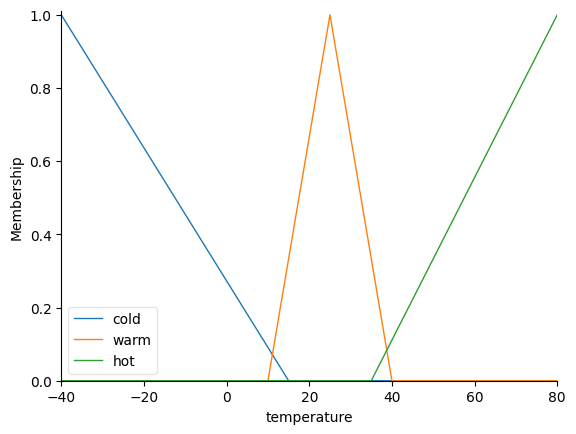

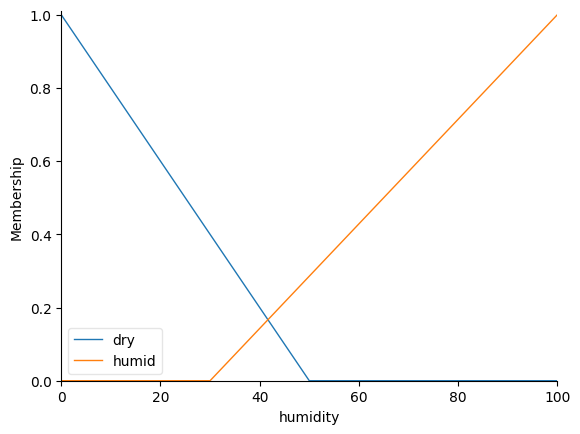

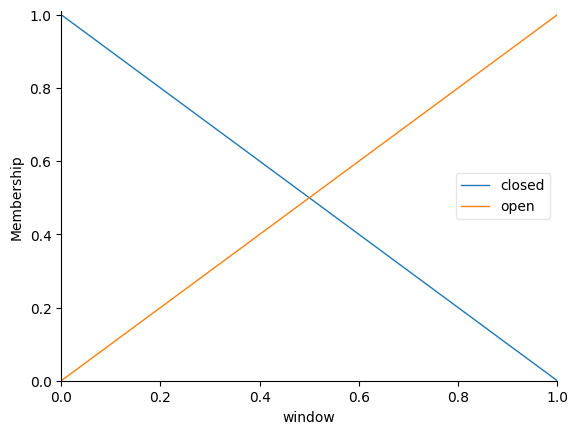

In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

varijable = {
    "AQI":0,
    "DaLiPadaKisa":False,
    "BrzinaVjetra":0,
    "VlaznostZraka":0,
    "TemperaturaZraka":0
}

vektor = np.array(list(varijable.values()))

"""vektor = []
for a in varijable:
    vektor.append(varijable[a])"""
    
"""vektor = [
    varijable["AQI"],
    varijable["BrzinaVjetra"],
    varijable["DaLiPadaKisa"],
    varijable["TemperaturaZraka"],
    varijable["VlaznostZraka"]
]"""
print(varijable)
print(vektor)

def do_fuzzy(vektor):
    val = 0
    # Define input variables
    temperature = ctrl.Antecedent(np.arange(-40, 81, 1), 'temperature')
    humidity = ctrl.Antecedent(np.arange(0, 101, 1), 'humidity')

    # Define output variable
    window = ctrl.Consequent(np.arange(0, 2, 1), 'window')  # 0 = closed, 1 = open


    # Temperature membership
    temperature['cold'] = fuzz.trimf(temperature.universe, [-40, -40, 15])
    temperature['warm'] = fuzz.trimf(temperature.universe, [10, 25, 40])
    temperature['hot'] = fuzz.trimf(temperature.universe, [35, 80, 80])

    # Humidity membership
    humidity['dry'] = fuzz.trimf(humidity.universe, [0, 0, 50])
    humidity['humid'] = fuzz.trimf(humidity.universe, [30, 100, 100])

    # Window control
    window['closed'] = fuzz.trimf(window.universe, [0, 0, 1])
    window['open'] = fuzz.trimf(window.universe, [0, 1, 1])


    rule1 = ctrl.Rule(temperature['hot'] & humidity['dry'], window['open'])
    rule2 = ctrl.Rule(temperature['cold'] | humidity['humid'], window['closed'])

    # Create control system
    window_ctrl = ctrl.ControlSystem([rule1, rule2])
    window_sim = ctrl.ControlSystemSimulation(window_ctrl)

    # Set input values
    window_sim.input['temperature'] = 65
    window_sim.input['humidity'] = 10
    print("Inputs before compute:", window_sim.input)
    # Compute result
    window_sim.compute()
    val = window_sim.output["window"]

    print("Window state (0=closed, 1=open):", val)
    temperature.view()
    humidity.view()
    window.view()
    return val


do_fuzzy(vektor)



{'TemperaturaZraka': 27, 'VlaznostZraka': 9, 'BrzinaVjetra': 0, 'AQI': 0, 'DaLiPadaKisa': True, 'VrijemeDana': 1}
[27  9  0  0  1  1]
Window state (0=closed, 1=open): 0.492260622077658
0.492260622077658


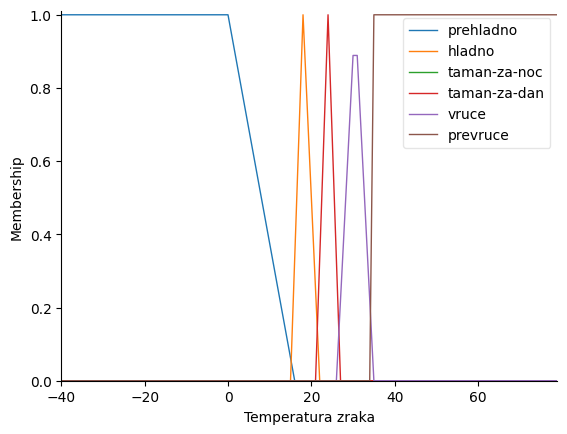

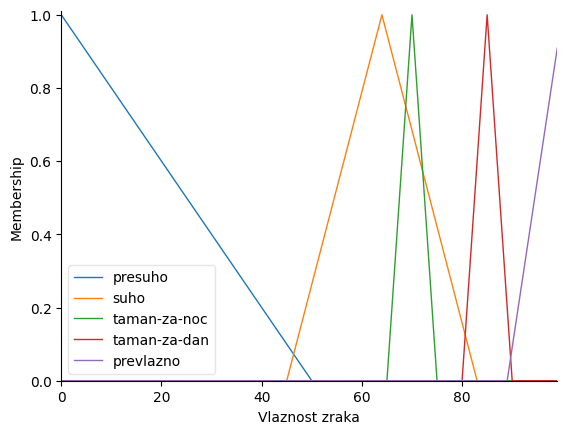

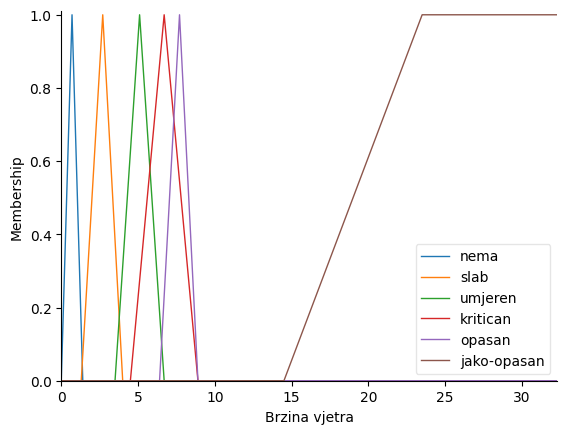

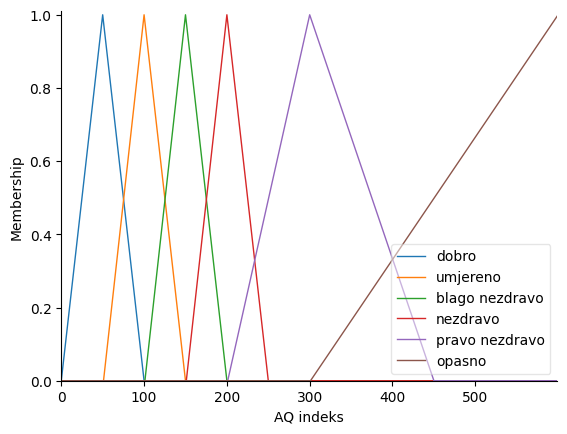

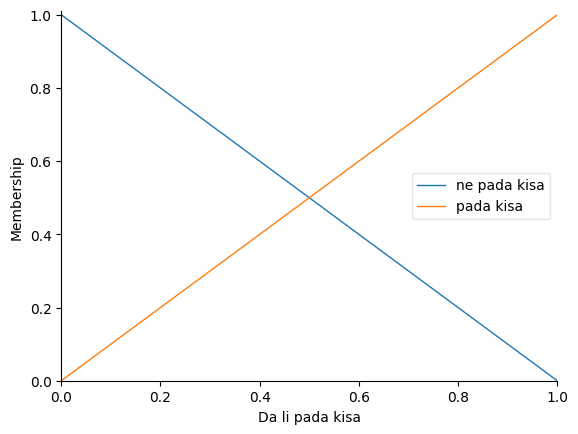

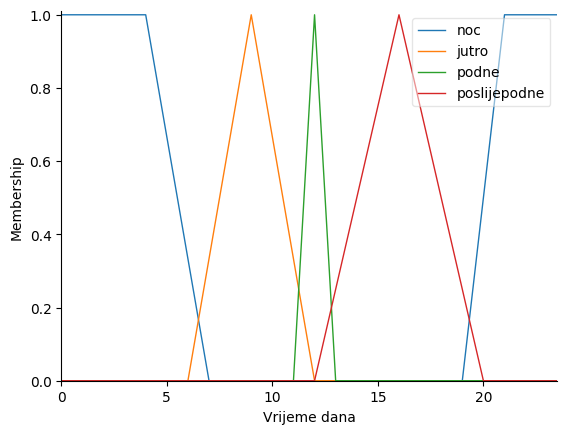

In [9]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import json

with open("paradajz.json", "r") as json_file:
    paradajzDict = json.load(json_file)



"""vektor = []
for a in varijable:
    vektor.append(varijable[a])"""
    
"""vektor = [
    varijable["AQI"],
    varijable["BrzinaVjetra"],
    varijable["DaLiPadaKisa"],
    varijable["TemperaturaZraka"],
    varijable["VlaznostZraka"]
]"""
print(varijable)
print(vektor)

def paradajz_fuzzy(vektor):
    val = 0

    # Define input variables
    lista_inputa = []
    for uvjet in paradajzDict["uvjeti"]:
        od = uvjet["Domen"][0]
        do = uvjet["Domen"][1]
        delta = uvjet["Domen"][2]
        lista_inputa.append(ctrl.Antecedent(np.arange(od,do,delta), uvjet["Varijabla"]))

    

    # Define output variable with more points
    prozor = ctrl.Consequent(np.arange(0, 1.1, 0.5), 'prozor')

    # Membership functions
    for i in range(len(lista_inputa)):
        lin_var = paradajzDict["uvjeti"][i]["Lingvisticki model varijable"]
        for e in lin_var:
            if e["ime"]=="noc":
                noc_morning = fuzz.trapmf(lista_inputa[i].universe, e["domen"][0])
                noc_evening = fuzz.trapmf(lista_inputa[i].universe, e["domen"][1])
                lista_inputa[i][e["ime"]] = np.fmax(noc_morning, noc_evening)
            elif len(e["domen"])==3:
                lista_inputa[i][e["ime"]]= fuzz.trimf(lista_inputa[i].universe, e["domen"])
            elif len(e["domen"])==4:
                lista_inputa[i][e["ime"]]= fuzz.trapmf(lista_inputa[i].universe, e["domen"])
    
    prozor['zatvori'] = fuzz.trimf(prozor.universe, [0, 0, 0.5])
    prozor['nista ne radi'] = fuzz.trimf(prozor.universe, [0.4, 0.5, 0.6])
    prozor['otvori'] = fuzz.trimf(prozor.universe, [0.5, 1, 1])
    
    temperatura = lista_inputa[0]
    vlaznost = lista_inputa[1]
    brzinaVjetra = lista_inputa[2]
    aqi = lista_inputa[3]
    daLiKisaPada = lista_inputa[4]
    vrijemeDana = lista_inputa[5]
    # Rules
    pravila = []
    pravila.append(ctrl.Rule(vrijemeDana['noc'] & temperatura['taman-za-dan'], prozor["otvori"]))
    pravila.append(ctrl.Rule(~vrijemeDana['noc'] & temperatura['taman-za-noc'], prozor["zatvori"]))
    pravila.append(ctrl.Rule(temperatura['prehladno'] | temperatura['hladno'],prozor["zatvori"]))
    pravila.append(ctrl.Rule(temperatura['vruce'] | temperatura['prevruce'],prozor["otvori"]))
    pravila.append(ctrl.Rule(~vrijemeDana['noc'] & temperatura['taman-za-dan'], prozor['nista ne radi']))
    pravila.append(ctrl.Rule(vlaznost['presuho'],prozor['otvori']))
    pravila.append(ctrl.Rule(vlaznost['suho'], prozor['otvori']))
    pravila.append(ctrl.Rule(vlaznost['prevlazno'] & ~daLiKisaPada["ne pada kisa"], prozor['otvori']))
    pravila.append(ctrl.Rule(~brzinaVjetra["nema"] & ~brzinaVjetra["slab"], prozor['zatvori']))
    pravila.append(ctrl.Rule(brzinaVjetra["slab"] & (vlaznost["suho"] | vlaznost["presuho"]), prozor['otvori']))
    pravila.append(ctrl.Rule(~brzinaVjetra["nema"] & (~vlaznost["taman-za-dan"] | ~vlaznost["taman-za-noc"]), prozor['zatvori']))
    pravila.append(ctrl.Rule(~aqi["dobro"] | ~aqi["umjereno"],prozor["zatvori"]))

    # Control system
    window_ctrl = ctrl.ControlSystem(pravila)
    window_sim = ctrl.ControlSystemSimulation(window_ctrl)

    # Set inputs

    #window_sim.input['temperature'] = 60
    #window_sim.input['humidity'] = 10
    i=0
    for e in paradajzDict["uvjeti"]:
        window_sim.input[e["Varijabla"]] = vektor[i]
        i+=1

    # Compute
    window_sim.compute()
    val = window_sim.output['prozor']

    #Views
    for e in lista_inputa:
        e.view()
    print("Window state (0=closed, 1=open):", val)


    return val

varijable = {
    "TemperaturaZraka":27,
    "VlaznostZraka":9,
    "BrzinaVjetra":2,
    "AQI":0,
    "DaLiPadaKisa":True,
    "VrijemeDana":1,
}

vektor = np.array(list(varijable.values()))

print(paradajz_fuzzy(vektor))

### ZAKLJUČAK I KRATKA REFLEKSIJA

### IZVORI

1. https://www.winter.hr/automatika.htm
1. https://cdn.sparkfun.com/assets/f/7/d/9/c/DHT22.pdf
1. https://cales.arizona.edu/hydroponictomatoes/system.htm
1. https://www.weather.gov/pqr/wind
1. https://stellinamarfa.com/fruits/how-much-wind-is-too-much-for-tomato-plants/
1. https://waqi.info/#/c/3.396/8.206/2.2z






### ULOGE ČLANOVA